In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Definimos fuente para los graficos
from matplotlib import rcParams
import matplotlib.font_manager as font_manager

font_dir = ['/home/daniufundar/Downloads/Archivo/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

rcParams['font.family'] = 'Archivo'

fundar_colors = ['#E27124','#AFA36E', '#5D896F','#7BB5C4', '#B3B3B3']

In [2]:
import platform

if platform.system() == "Windows":
    pathfolder = 'path_for_Windows'
elif platform.system() == "Linux":
    if platform.uname()[2] == "5.15.0-57-generic":
        pathfolder = '/home/daniufundar/Documents/Fundar/indice-desigualdad-genero-fundar/'
    elif platform.uname()[2] == "version2":
        pathfolder = '/Users/danielarisaro/Documents/fundar/indice-desigualdad-genero/'
elif platform.system() == "Darwin":
    pathfolder = '/Users/danielarisaro/Documents/fundar/indice-desigualdad-genero/'
else:
    raise Exception("Unsupported operating system")


In [3]:
pathfolder = '/home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/'
pathinput = pathfolder + 'data_input/'

filename_hogar = 'hogar_T'
filename_personas = 'personas_T'

list_anios = [20, 21]
list_trimestres = [1, 2, 3, 4]

In [26]:
for i, it in enumerate(list_trimestres):
    for j, janios in enumerate(list_anios):

        filename = filename_personas + str(it) + str(janios) + '.txt'
        print(filename)
        df = pd.read_csv(pathinput + filename, delimiter=';', low_memory=False)

personas_T120.txt
personas_T121.txt
personas_T220.txt
personas_T221.txt
personas_T320.txt
personas_T321.txt
personas_T420.txt
personas_T421.txt


In [57]:
## Defino funciones dimension mercado de trabajo e ingresos

# Componente: Inserción laboral

# T1. 
# Variable: Actividad productiva
# Indicador: Ratio M/V en tasa de empleo

def ratio_tasa_empleo(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa de empleo M/V desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    # Check if the necessary columns exist in the input DataFrame
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA']):
        raise ValueError("El DataFrame de entrada debe tener las siguientes columnas: 'CH04', 'CH06', 'ESTADO', 'PONDERA'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    numerador = df_temp[df_temp['ESTADO']==1].groupby(['CH04', var])['PONDERA'].sum()       # agrupo por genero y provincia y sumo
    
    denominador = df_temp.groupby(['CH04', var])['PONDERA'].sum()
    df_tasa = numerador.div(denominador, fill_value=np.nan)
    df_tasa = df_tasa.to_frame().unstack(level=0)  
    
    ratio = (df_tasa['PONDERA'][2]/df_tasa['PONDERA'][1] * 100).to_frame()
    ratio.rename(columns={0: 'Actividad productiva'}, inplace=True)

    # Calculate error

    error = pd.DataFrame(index=ratio.index)

    return ratio, error


# T2. 
# Variable: Búsqueda de trabajo
# Indicador: Ratio M/V en tasa de desempleo

def ratio_tasa_desempleo(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa de desempleo M/V desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """
    # Check if the necessary columns exist in the input DataFrame
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA']):
        raise ValueError("The input DataFrame must have the following columns: 'CH04', 'CH06', 'ESTADO', 'PONDERA'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')                                           
    numerador = df_temp[df_temp['ESTADO']==2].groupby(['CH04', var])['PONDERA'].sum()               # agrupo por genero y provincia y sumo
    df_estado = df_temp[(df_temp['ESTADO'] == 1) | (df_temp['ESTADO'] == 2)]                        # selecciona las filas donde la columna ESTADO tenga un valor igual a 1 o 2 (personas activas)
    denominador = df_estado.groupby(['CH04', var])['PONDERA'].sum()                                 # agrupo por genero y provincia y sumo
    df_tasa = (numerador / denominador).to_frame().unstack(level=0)                                 # calculo tasa

    ratio = (df_tasa['PONDERA'][1]/df_tasa['PONDERA'][2] * 100).to_frame()                          # el ratio es V/M para que quede elevado a la menos 1
    ratio.rename(columns={0: 'Búsqueda de trabajo'}, inplace=True)

    error = 'a definir'

    return ratio, error

# T3.
# Variable: Acceso a derechos laborales
# Indicador: Ratio M/V en tasa de empleo asalariado con descuento jubilatorio

def ratio_tasa_registro(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa de informalidad M/V desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    # Check if the necessary columns exist in the input DataFrame
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA', 'CAT_OCUP', 'PP07H']):
        raise ValueError("The input DataFrame must have the following columns: 'CH04', 'CH06', 'ESTADO', 'PONDERA', 'CAT_OCUP', 'PP07H'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    df_estado = df_temp[(df_temp['ESTADO']==1) & (df_temp['CAT_OCUP']==3)]                      # Población ocupada asalariada
    numerador = df_estado[df_estado['PP07H']==1].groupby(['CH04', var])['PONDERA'].sum()        # Población ocupada asalariada con descuento jubilatorio
    denominador = df_estado.groupby(['CH04', var])['PONDERA'].sum()
    df_tasa = (numerador / denominador).to_frame().unstack(level=0)                             # calculo tasa

    ratio = (df_tasa['PONDERA'][2]/df_tasa['PONDERA'][1] * 100).to_frame()                      # Calculo ratio
    ratio.rename(columns={0: 'Acceso a derechos laborales'}, inplace=True)

    error = pd.DataFrame(index=ratio.index)
    error = 'a definir'

    # for i in ratio.index:
    #     if denominador[i] == 0:
    #         error[i] = 'Warning: El denominador es cero, no se puede calcular el ratio'
    #     else:
    #         error[i] = np.sqrt((ratio[i]*(1-ratio[i])/denominador[i]))

    return ratio, error

# T4. 
# Variable: Participación en el trabajo remunerado
# Indicador: Ratio M/V en Horas semanales promedio destinadas al trabajo remunerado

def ratio_tasa_horas_remuneradas(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa de horas remuneradas M/V desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    # Check if the necessary columns exist in the input DataFrame       
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA', 'CAT_OCUP', 'PP07H']):
        raise ValueError("The input DataFrame must have the following columns: 'CH04', 'CH06', 'ESTADO', 'PONDERA', 'CAT_OCUP', 'PP07H'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    df_temp['PP3E_TOT'] = pd.to_numeric(df_temp['PP3E_TOT'], errors='coerce') # coerce invalid parsing to NaN

    df_estado = df_temp[(df_temp['ESTADO']==1) & (df_temp['PP3E_TOT']>0) & (df_temp['PP3E_TOT']!=999)]  
    df_tasa = df_estado.groupby(['CH04', var])['PONDERA'].mean().to_frame().unstack(level=0)
    
    ratio = (df_tasa['PONDERA'][2]/df_tasa['PONDERA'][1] * 100).to_frame()
    ratio.rename(columns={0: 'Participación en el trabajo remunerado'}, inplace=True)
    
    error = 'a definir'

    return ratio, error


# T5. 
# Variable: Horas trabajadas en el hogar
# Indicador: Ratio M/V en Horas semanales promedio destinadas al TNR en el hogar

        # en funcion de la enut


# Componente: Autonomía económica

# T6. 
# Variable: Dependencia económica 
# Indicador: Ratio M/V en Población inactiva y que no estudia sin ingresos propios

def ratio_tasa_poblacion_dependiente(df, tipo='Aglomerado', base='Individual'):

    # En este caso dividir el indicador segun algun percentil de ingresos. Por ejemplo de 90 a 60. Ver literatura al respecto 

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios en tasa M/V de población inactiva que no estudia y no tiene ingresos propios, desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    # Check if the necessary columns exist in the input DataFrame
    if not all(col in df.columns for col in ['CH04', 'CH06', 'ESTADO', 'PONDERA', 'P47T', 'CH10', 'PONDII']):
        raise ValueError("The input DataFrame must have the following columns: 'CH04', 'CH06', 'ESTADO', 'PONDERA', 'P47T', 'CH10', 'PONDII'")
        
    # Check if the input value of "tipo" is valid
    if tipo not in ['Aglomerado', 'Urbano']:
        return None, 'Error: tipo debe ser "Aglomerado" o "Urbano"'
    if base not in ['Individual', 'Hogar']:
        return None, 'Error: base debe ser "Individual" o "Hogar"'
    if not isinstance(df, pd.DataFrame):
        return None, 'Error: df debe ser un DataFrame de pandas'
    
    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')

    numerador = df_temp[(df_temp['ESTADO']==3) & (df_temp['P47T']==0) & (df_temp['CAT_INAC']!=3)].groupby(['CH04', var])['PONDII'].sum()
    denominador = df_temp.groupby(['CH04', var])['PONDERA'].sum()
    df_tasa = (numerador / denominador).to_frame().unstack(level=0)                         # calculo tasa

    ratio = (df_tasa[0][2]/df_tasa[0][1] * 100).to_frame()
    ratio.rename(columns={0: 'Dependencia económica'}, inplace=True)
    
    error = pd.DataFrame(index=ratio.index)
    error = 'a definir'


    return ratio, error

# T7. 
# Variable: Ingreso salarial
# Indicador: Ratio M/V en Ingreso salarial promedio mensual

def ratio_ingreso_laboral_mensual(df, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios del ingreso individual mensual laboral de M/V, desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """

    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    df_estado = df_temp[(df_temp['ESTADO'] == 1) & (~df_temp['CAT_OCUP'].isin([1, 4, 9]))]

    df_ingreso = df_estado[(df_estado['P21']>0) & (df_estado['P21']!=-9)].sum()
    df_tasa = df_ingreso.groupby(['CH04', var])['PONDIIO'].median().to_frame().unstack(level=0)  
    
    ratio = (df_tasa['PONDIIO'][2]/df_tasa['PONDIIO'][1] * 100).to_frame()
    ratio.rename(columns={0: 'Ingreso laboral'}, inplace=True)
    
    error = 'a definir'

    return ratio, error


# T8. 
# Variable: Pobreza
# Indicador: Ratio M/V en Población con ingreso total individual inferior a LP

def ratio_pobreza(df, CBT, tipo='Aglomerado', base='Individual'):

    """
    INPUTS
    df: DataFrame. Tabla input EPH
    tipo: string. Tipo de encuesta de la EPH, Aglomerado o Urbano. Default Aglomerado
    base: string. Tipo de base de la encuesta de la EPH, Individual u Hogar. Default Individual

    OUTPUTS
    ratio: DataFrame. Tabla con Ratios del ingreso individual mensual laboral de M/V, desagregado por Aglomerado o Provincia
    error: DataFrame. Tabla con los errores asociados a los Ratios

    """


    if tipo=='Aglomerado':
        var = 'AGLOMERADO' 
    elif tipo=='Urbano':
        var = 'PROVINCIA'

    df_temp = df.query('CH06 >= 16 & CH06 < 65')
    df_estado = df_temp[(df_temp['ESTADO'] == 1) & (~df_temp['CAT_OCUP'].isin([1, 4, 9]))]

    numerador = df_estado[(df_estado['P21']>0) & (df_estado['P21']!=-9)].sum()
    denominador = 'TBD'
    df_tasa = df_estado.groupby(['CH04', var])['PONDIIO'].mean().to_frame().unstack(level=0)  
    
    ratio = (df_tasa['PONDIIO'][2]/df_tasa['PONDIIO'][1] * 100).to_frame()
    ratio.rename(columns={0: 'Ingreso laboral'}, inplace=True)
    
    error = 'a definir'

    return ratio, error



def df_merge_ratios(ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza, diccionario):

    df_ratio = pd.concat([ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                    ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza], axis=1)
                    
    df_ratio['Nombre'] = df_ratio.index.map(diccionario)

    df_ratio = df_ratio.set_index('Nombre')
    
    return df_ratio

In [111]:
np.array([df.columns])

array([['CODUSU', 'ANO4', 'TRIMESTRE', 'NRO_HOGAR', 'COMPONENTE', 'H15',
        'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA', 'CH03', 'CH04',
        'CH05', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12',
        'CH13', 'CH14', 'CH15', 'CH15_COD', 'CH16', 'CH16_COD',
        'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'IMPUTA', 'PP02C1',
        'PP02C2', 'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7',
        'PP02C8', 'PP02E', 'PP02H', 'PP02I', 'PP03C', 'PP03D',
        'PP3E_TOT', 'PP3F_TOT', 'PP03G', 'PP03H', 'PP03I', 'PP03J',
        'INTENSI', 'PP04A', 'PP04B_COD', 'PP04B1', 'PP04B2',
        'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA', 'PP04C', 'PP04C99',
        'PP04D_COD', 'PP04G', 'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA',
        'PP05C_1', 'PP05C_2', 'PP05C_3', 'PP05E', 'PP05F', 'PP05H',
        'PP06A', 'PP06C', 'PP06D', 'PP06E', 'PP06H', 'PP07A', 'PP07C',
        'PP07D', 'PP07E', 'PP07F1', 'PP07F2', 'PP07F3', 'PP07F4',
        'PP07F5', 'PP07G1', 'PP07G2', 'P

array([ 3,  1,  2,  5,  4,  8,  6,  9, 10,  7])

In [108]:
df[df['CH03']!=2]                 # descartando conyuges y me quedo con hogares monopopamrtales
df[df['CH03']==1]                   # tomo el jefe, despues tomo si es M o V 

si o si df[df['CH06']<6]

41328

In [14]:
#cod_provincia
dict_cod_provincia = {2: "Ciudad de Buenos Aires",
 6: "Buenos Aires",
 10: "Catamarca",
 14: "Córdoba",
 18: "Corrientes",
 22: "Chaco",
 26: "Chubut",
 30: "Entre Ríos",
 34: "Formosa",
 38: "Jujuy",
 42: "La Pampa",
 46: "La Rioja",
 50: "Mendoza",
 54: "Misiones",
 58: "Neuquén",
 62: "Río Negro",
 66: "Salta",
 70: "San Juan",
 74: "San Luis",
 78: "Santa Cruz",
 82: "Santa Fe",
 86: "Santiago del Estero",
 90: "Tucumán",
 94: "Tierra del Fuego"}

In [15]:
#cod_aglomerado

dict_cod_aglomerado = {2: "Gran La Plata",
3: "Bahía Blanca - Cerri",
4: "Gran Rosario",
5: "Gran Santa Fé",
6: "Gran Paraná",
7: "Posadas",
8: "Gran Resistencia",
9: "Comodoro Rivadavia - Rada Tilly",
10:" Gran Mendoza",
12: "Corrientes",
13: "Gran Córdoba",
14: "Concordia",
15: "Formosa",
17: "Neuquén – Plottier",
18: "Santiago del Estero - La Banda",
19: "Jujuy-Palpalá",
20: "Río Gallegos",
22: "Gran Catamarca",
23: "Gran Salta",
25: "La Rioja",
26: "Gran San Luis",
27: "Gran San Juan",
29: "Gran Tucumán - Tafí Viejo",
30: "Santa Rosa – Toay",
31: "Ushuaia - Río Grande",
32: "Ciudad Autónoma de Buenos Aires",
33: "Partidos del GBA",
34: "Mar del Plata",
36: "Río Cuarto",
38: "San Nicolás – Villa Constitución",
91: "Rawson – Trelew",
93: "Viedma – Carmen de Patagones"}

In [16]:
ratio_empleo, error_empleo = ratio_tasa_empleo(df, tipo='Aglomerado', base='Individual')

In [24]:
ratio_empleo, error_empleo = ratio_tasa_empleo(df, tipo='Aglomerado', base='Individual')
ratio_desempleo, error_desempleo = ratio_tasa_desempleo(df, tipo='Aglomerado', base='Individual')
ratio_informalidad, error_informalidad = ratio_tasa_registro(df, tipo='Aglomerado', base='Individual')
ratio_horas_remuneradas, error_horas_remuneradas = ratio_tasa_horas_remuneradas(df, tipo='Aglomerado', base='Individual')
ratio_poblacion_dependiente, error_poblacion_dependiente = ratio_tasa_poblacion_dependiente(df, tipo='Aglomerado', base='Individual')
ratio_ingreso_laboral, error_ingreso_laboral = ratio_ingreso_laboral_mensual(df, tipo='Aglomerado', base='Individual')
ratio_pobreza, error_pobreza = ratio_pobreza(df, CBT=111444, tipo='Aglomerado', base='Individual')

df_ratio = df_merge_ratios(ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza, dict_cod_aglomerado)

In [25]:
df_ratio

,Actividad productiva,Búsqueda de trabajo,Acceso a derechos laborales,Participación en el trabajo remunerado,Dependencia económica,Ingreso laboral,Pobreza
Nombre,,,,,,,
Gran La Plata,75.831574,167.185763,102.470115,95.492536,328.561065,95.448590,111.477784
Bahía Blanca - Cerri,80.766722,68.306513,93.093630,89.479429,439.059448,87.981711,112.003840
Gran Rosario,74.486199,89.391163,78.807218,86.351548,383.019801,86.654506,109.095910
Gran Santa Fé,71.327304,45.984817,95.099459,102.712655,414.723585,101.592063,109.735556
Gran Paraná,70.470463,66.757131,93.236622,97.005348,295.733742,97.863454,110.203699
Posadas,79.451551,152.637377,87.059944,102.510534,348.683682,100.180560,110.450946
Gran Resistencia,69.154015,84.109833,103.388373,101.633323,182.614106,100.334030,105.323321
Comodoro Rivadavia - Rada Tilly,68.335409,134.680642,83.515464,85.995562,279.448587,84.513757,109.677274
Gran Mendoza,78.340505,62.132243,96.415885,94.906288,273.214308,95.567680,105.863247


personas_T120.txt
personas_T220.txt
personas_T320.txt
personas_T420.txt
personas_T121.txt
personas_T221.txt
personas_T321.txt
personas_T421.txt


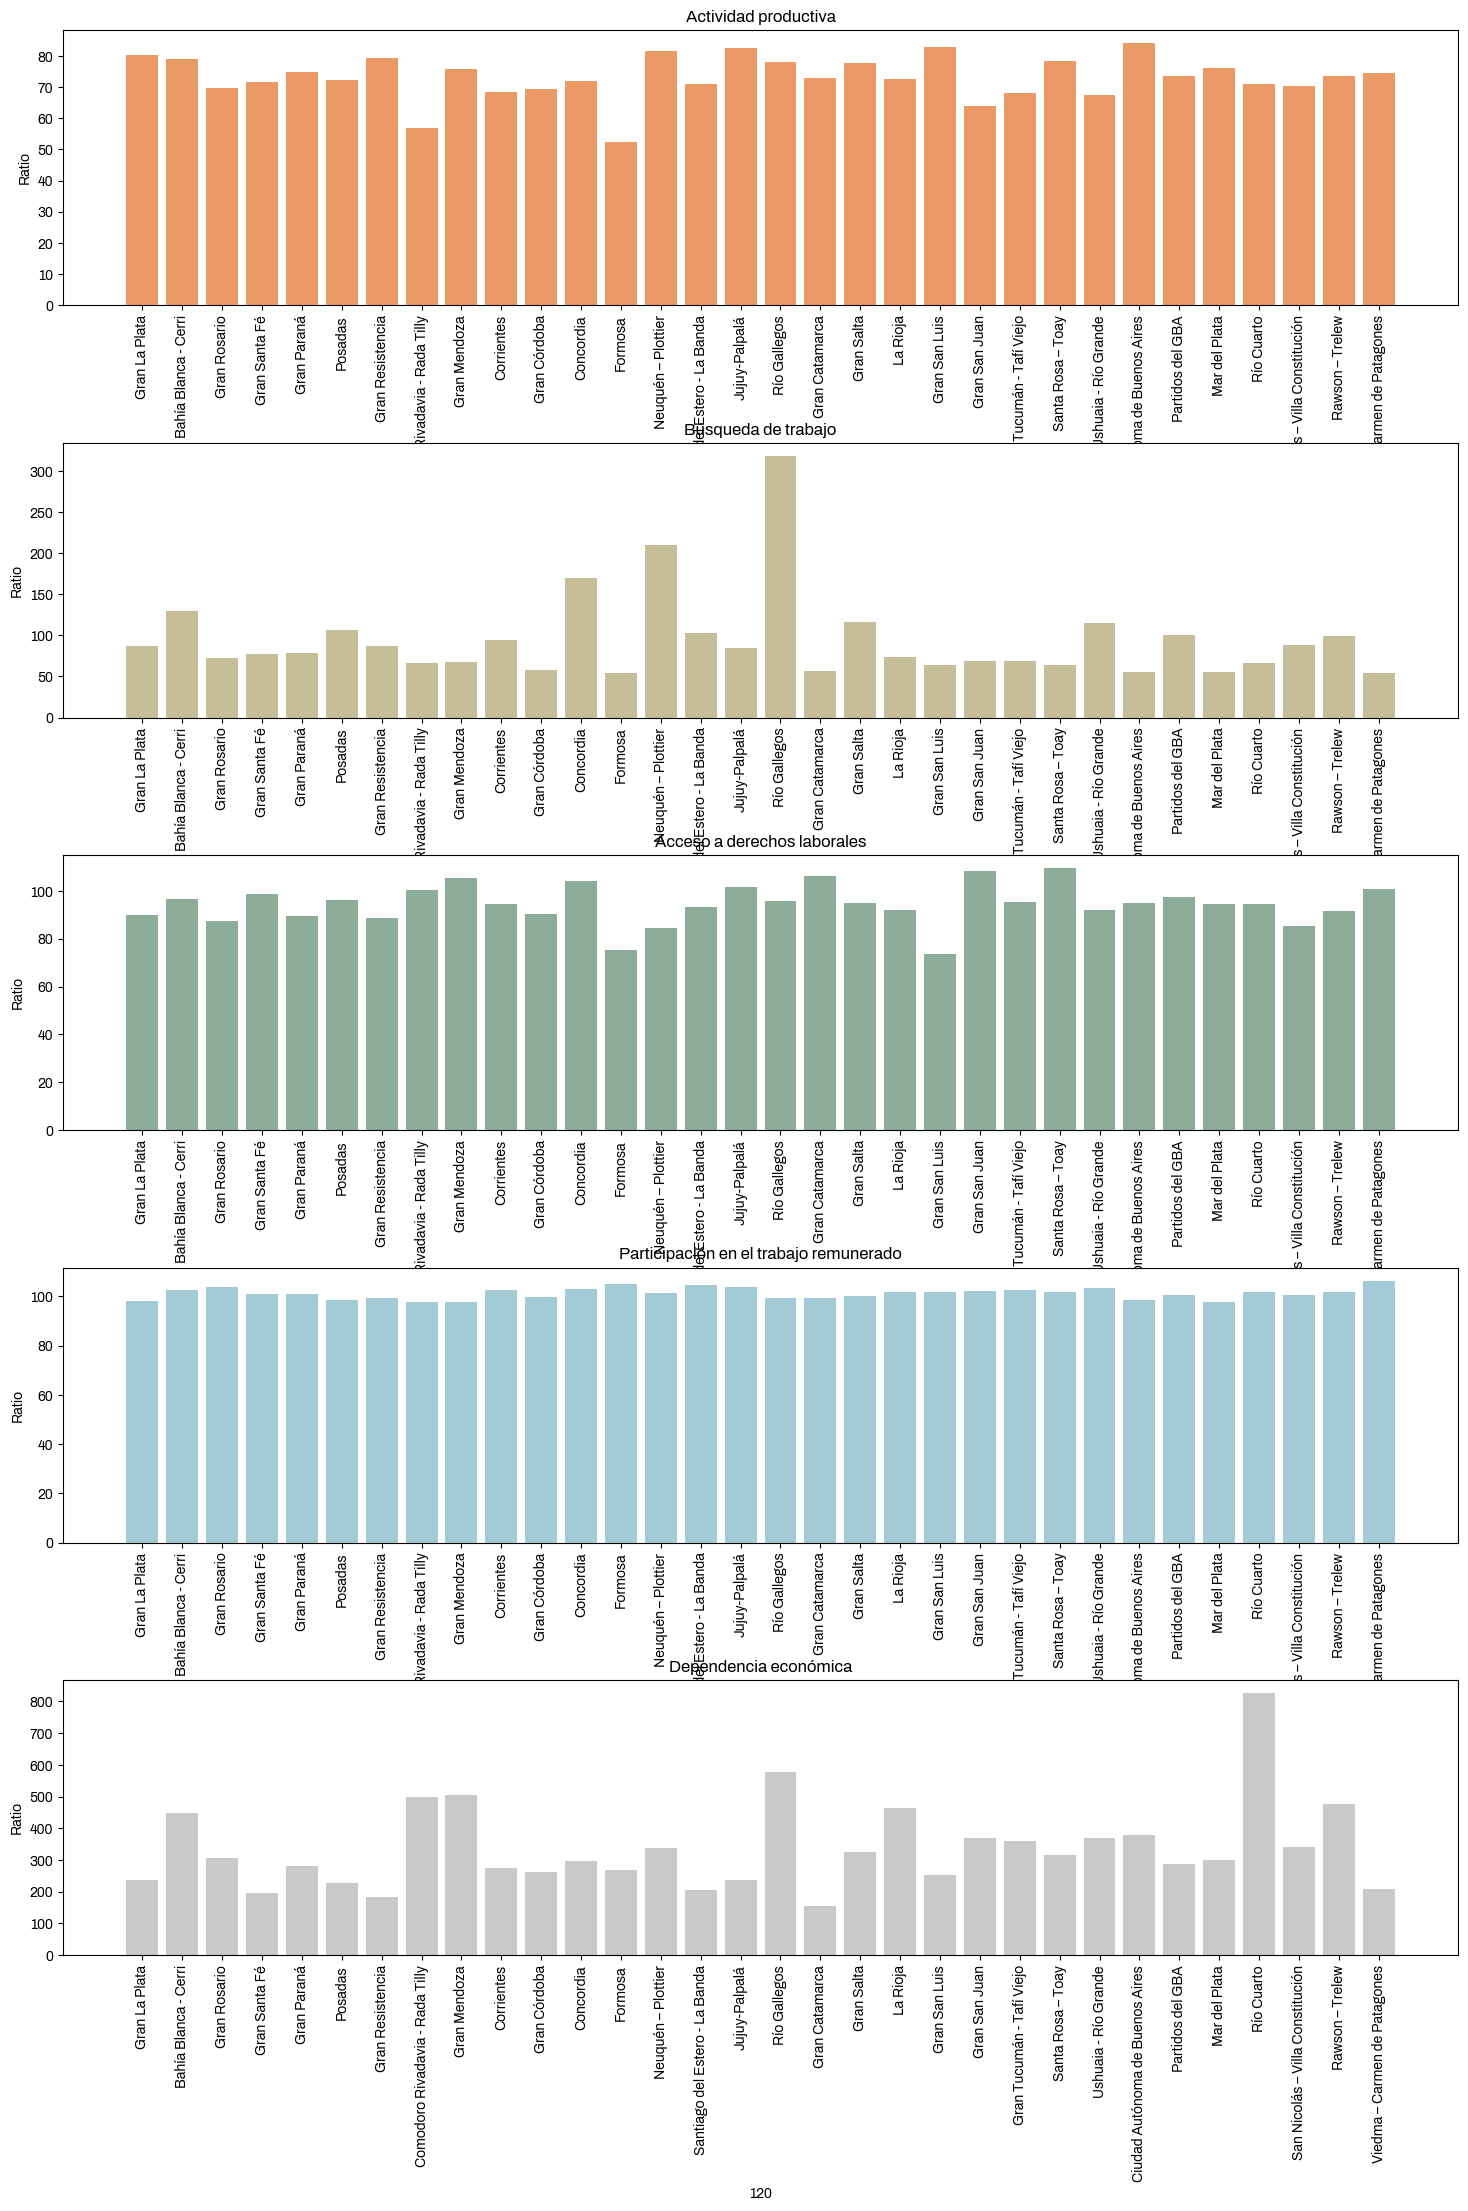

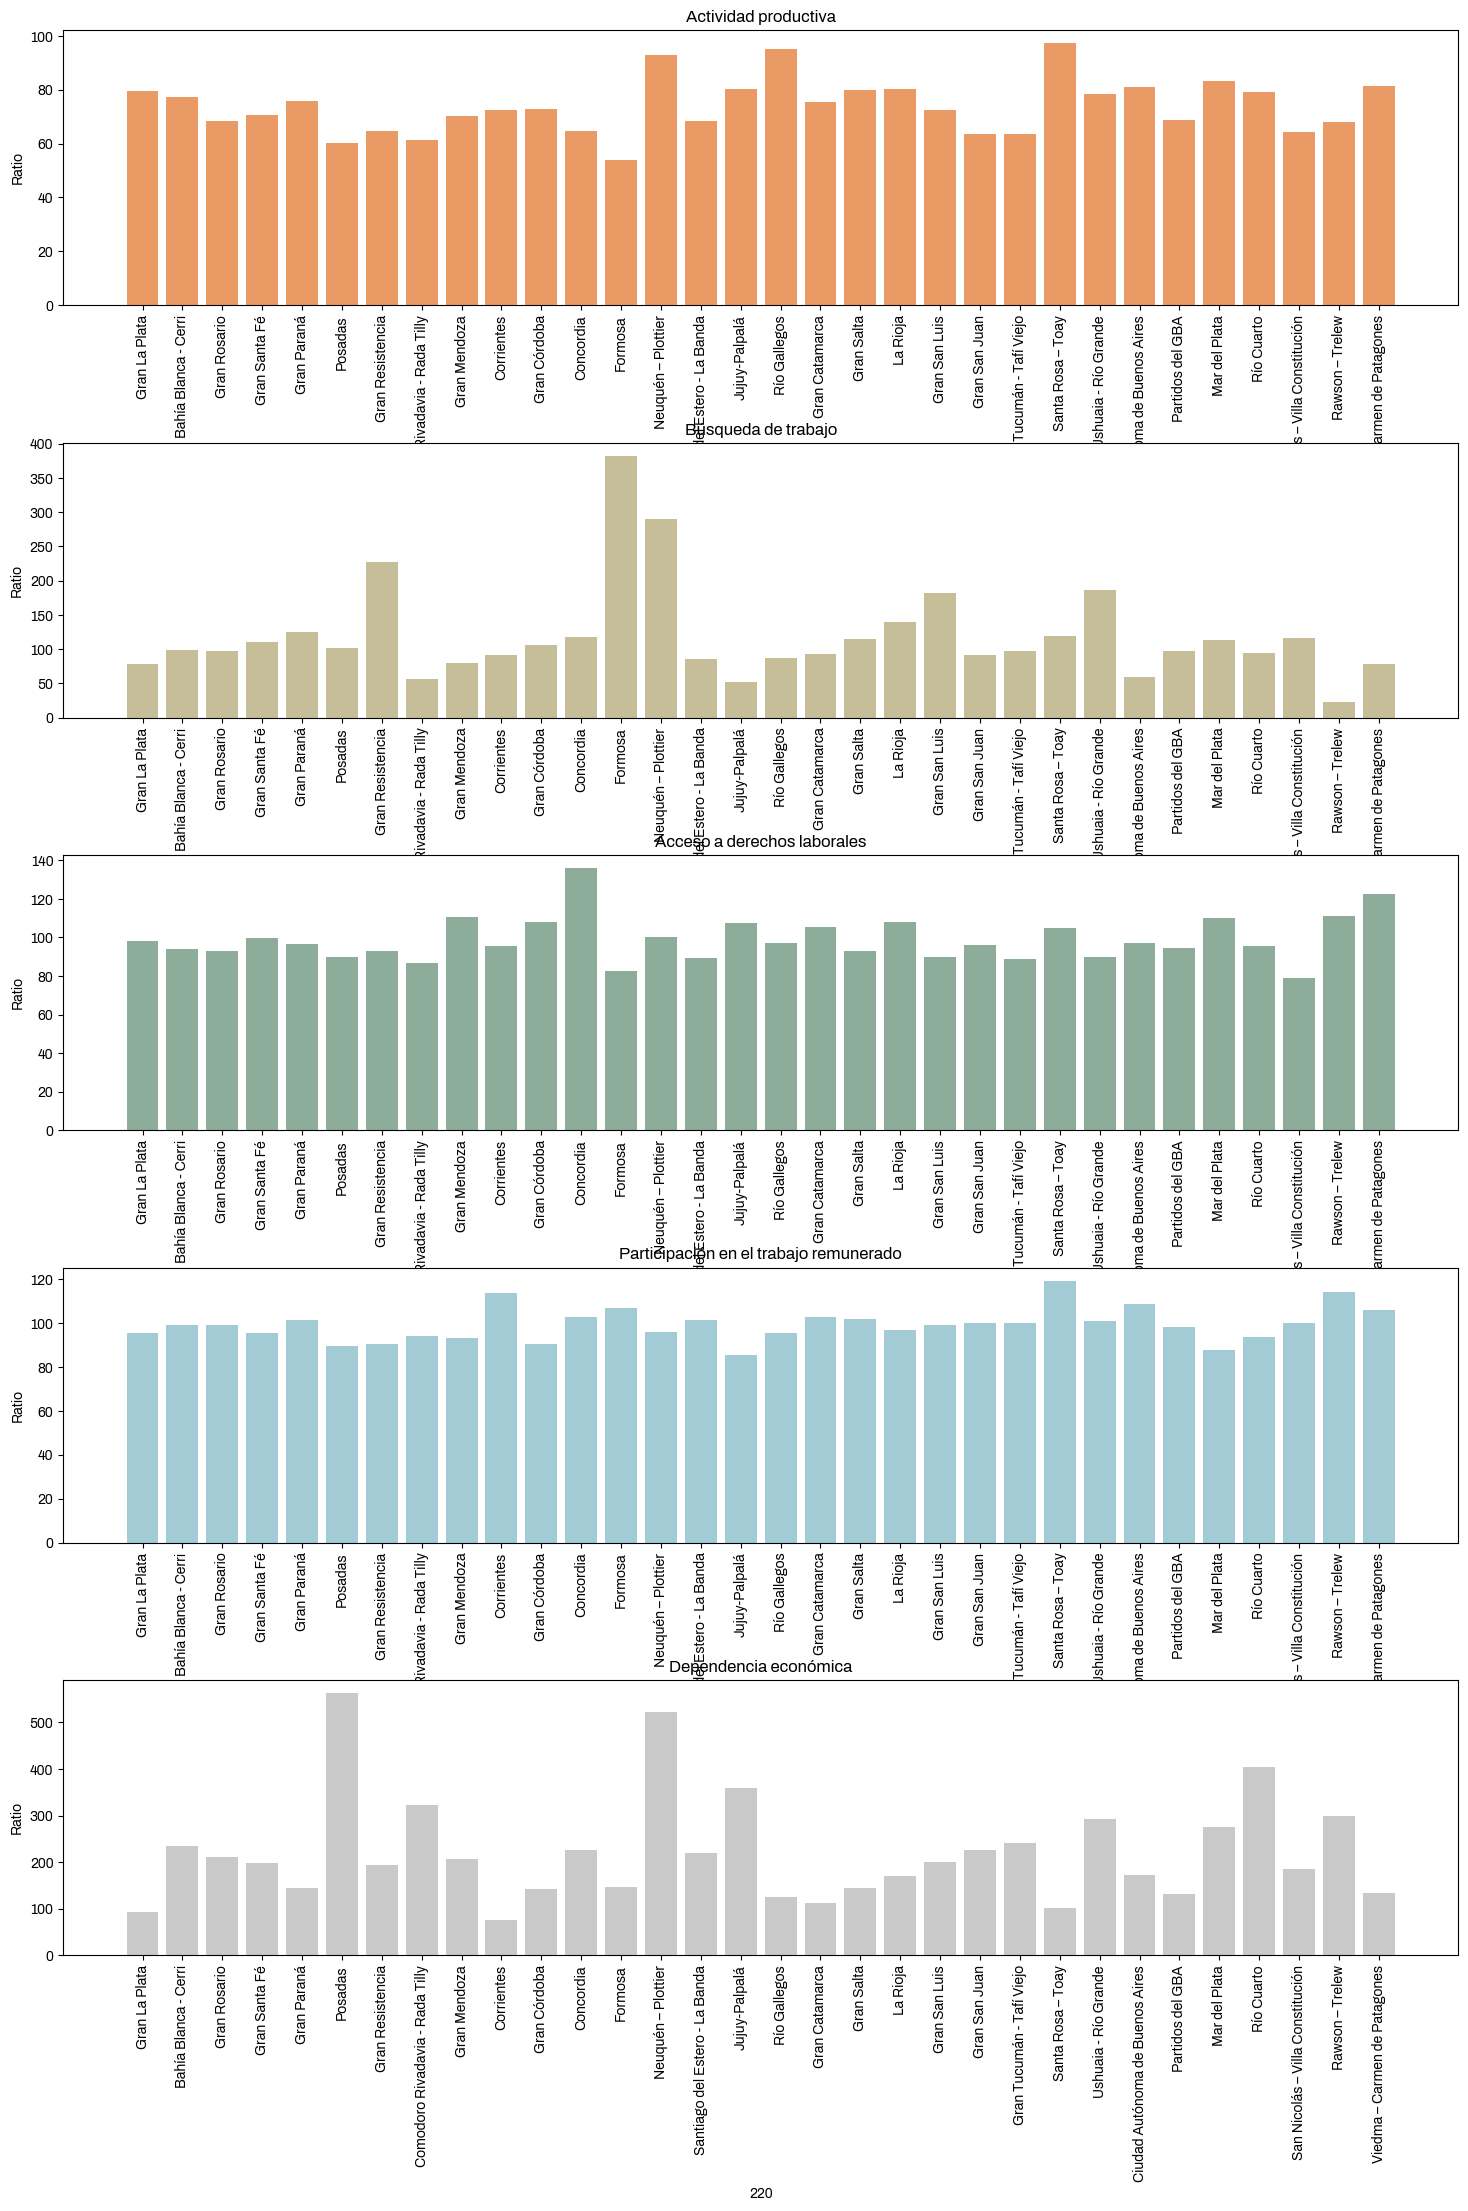

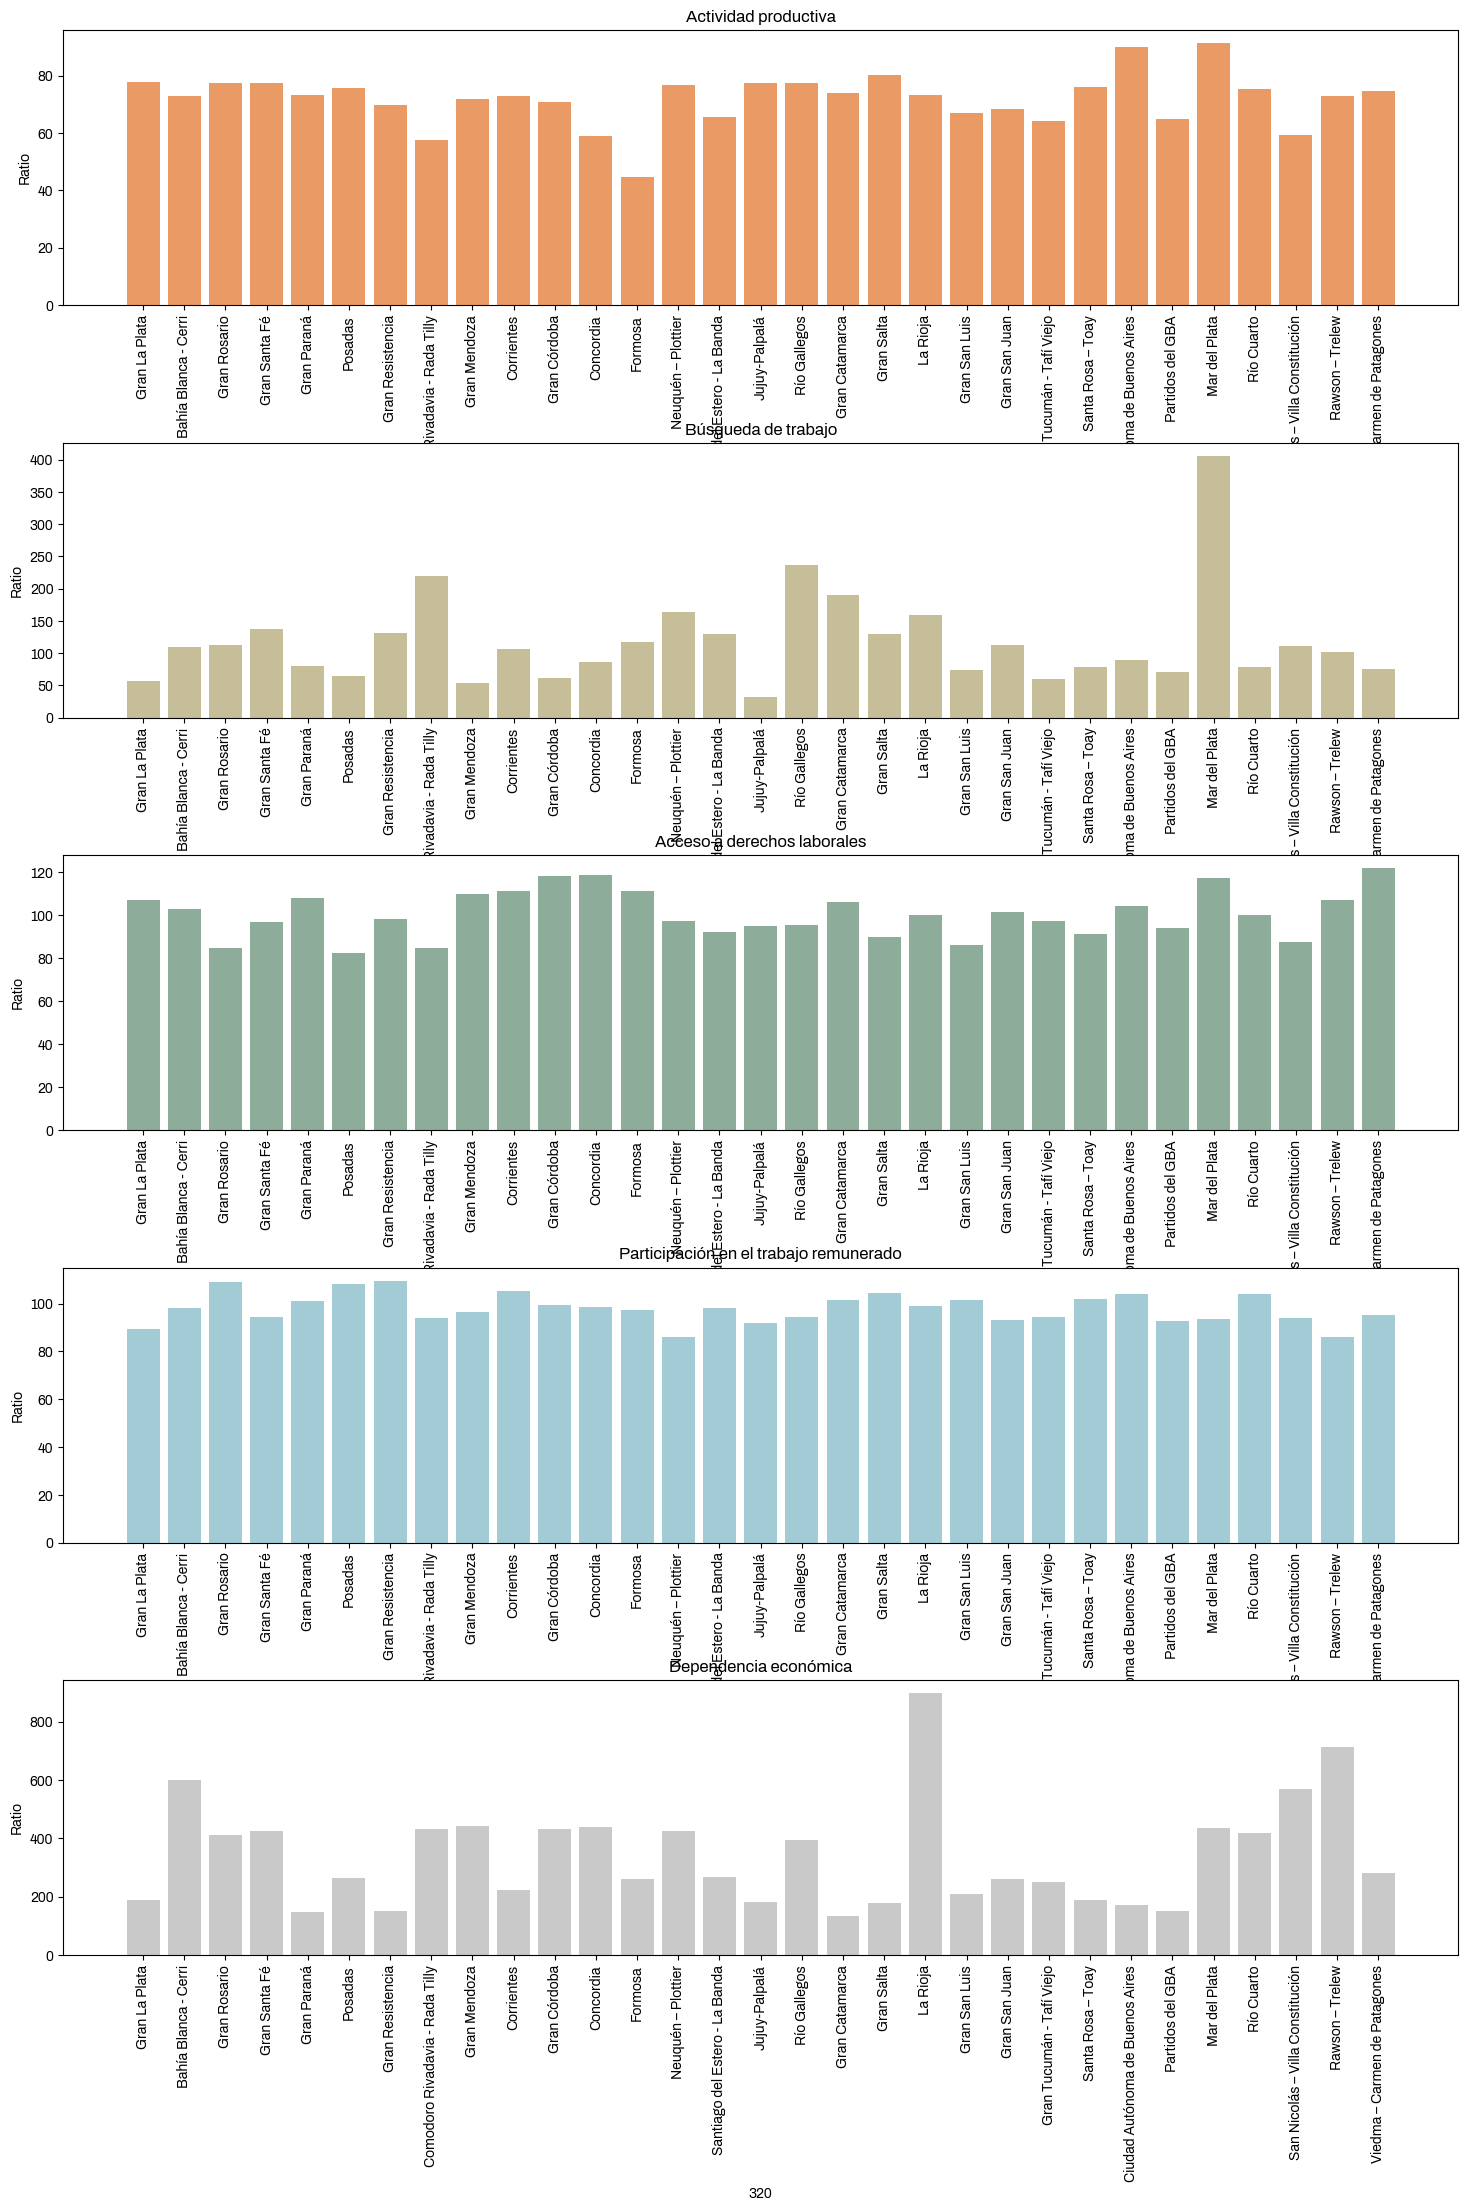

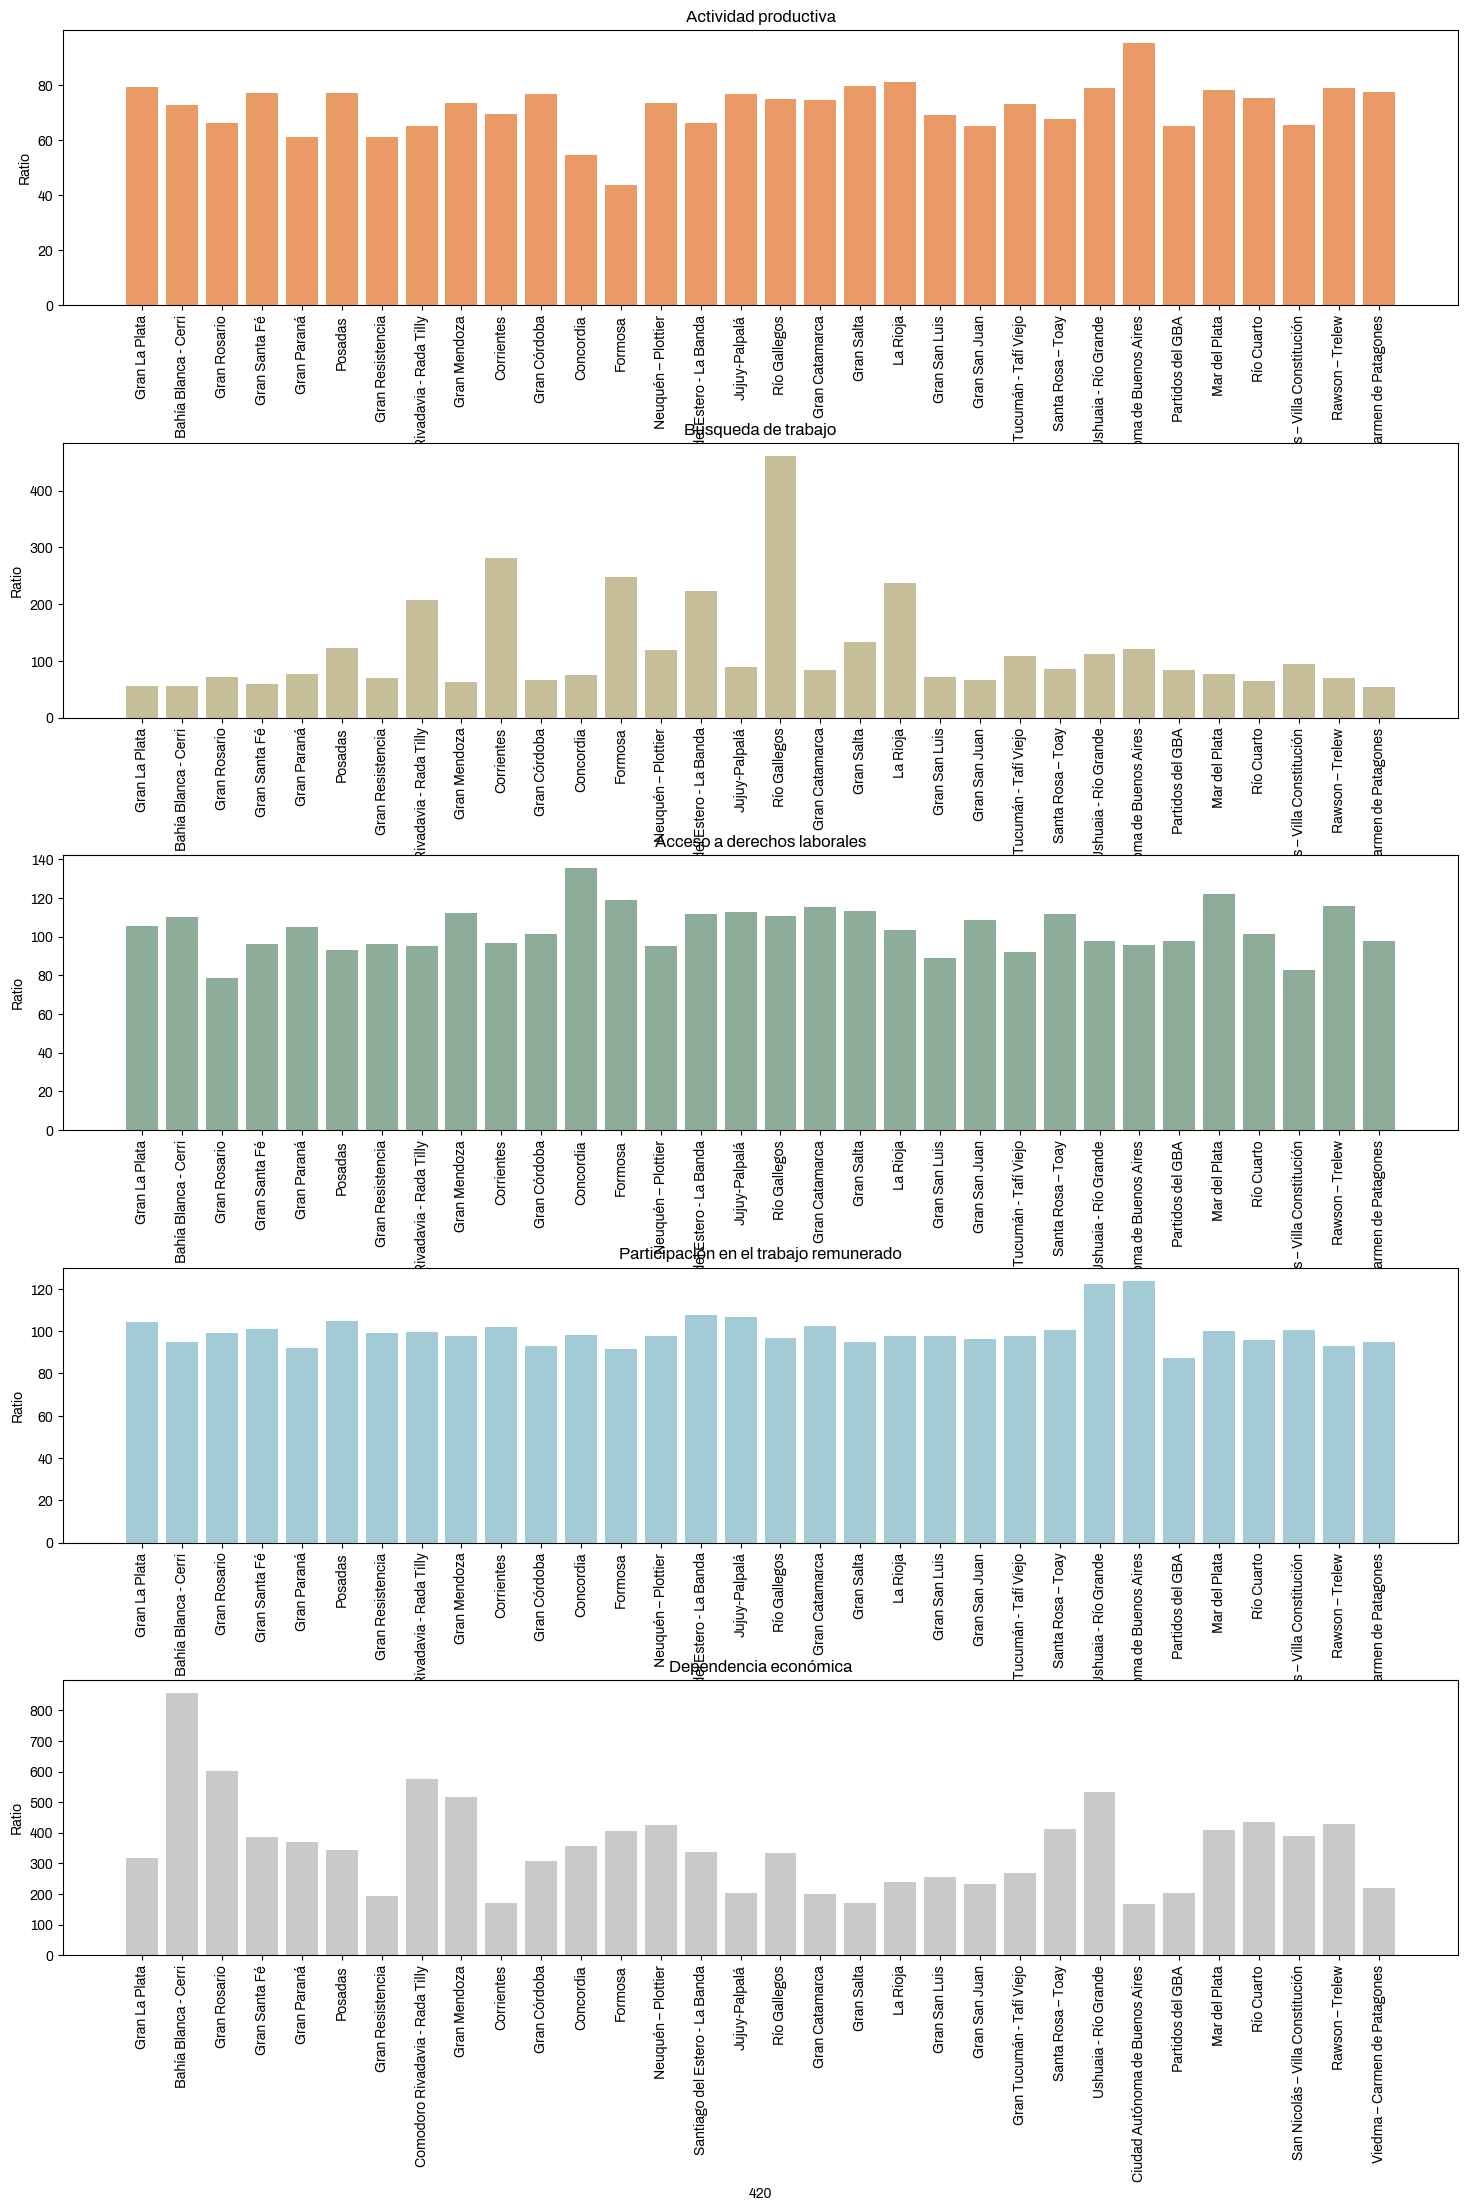

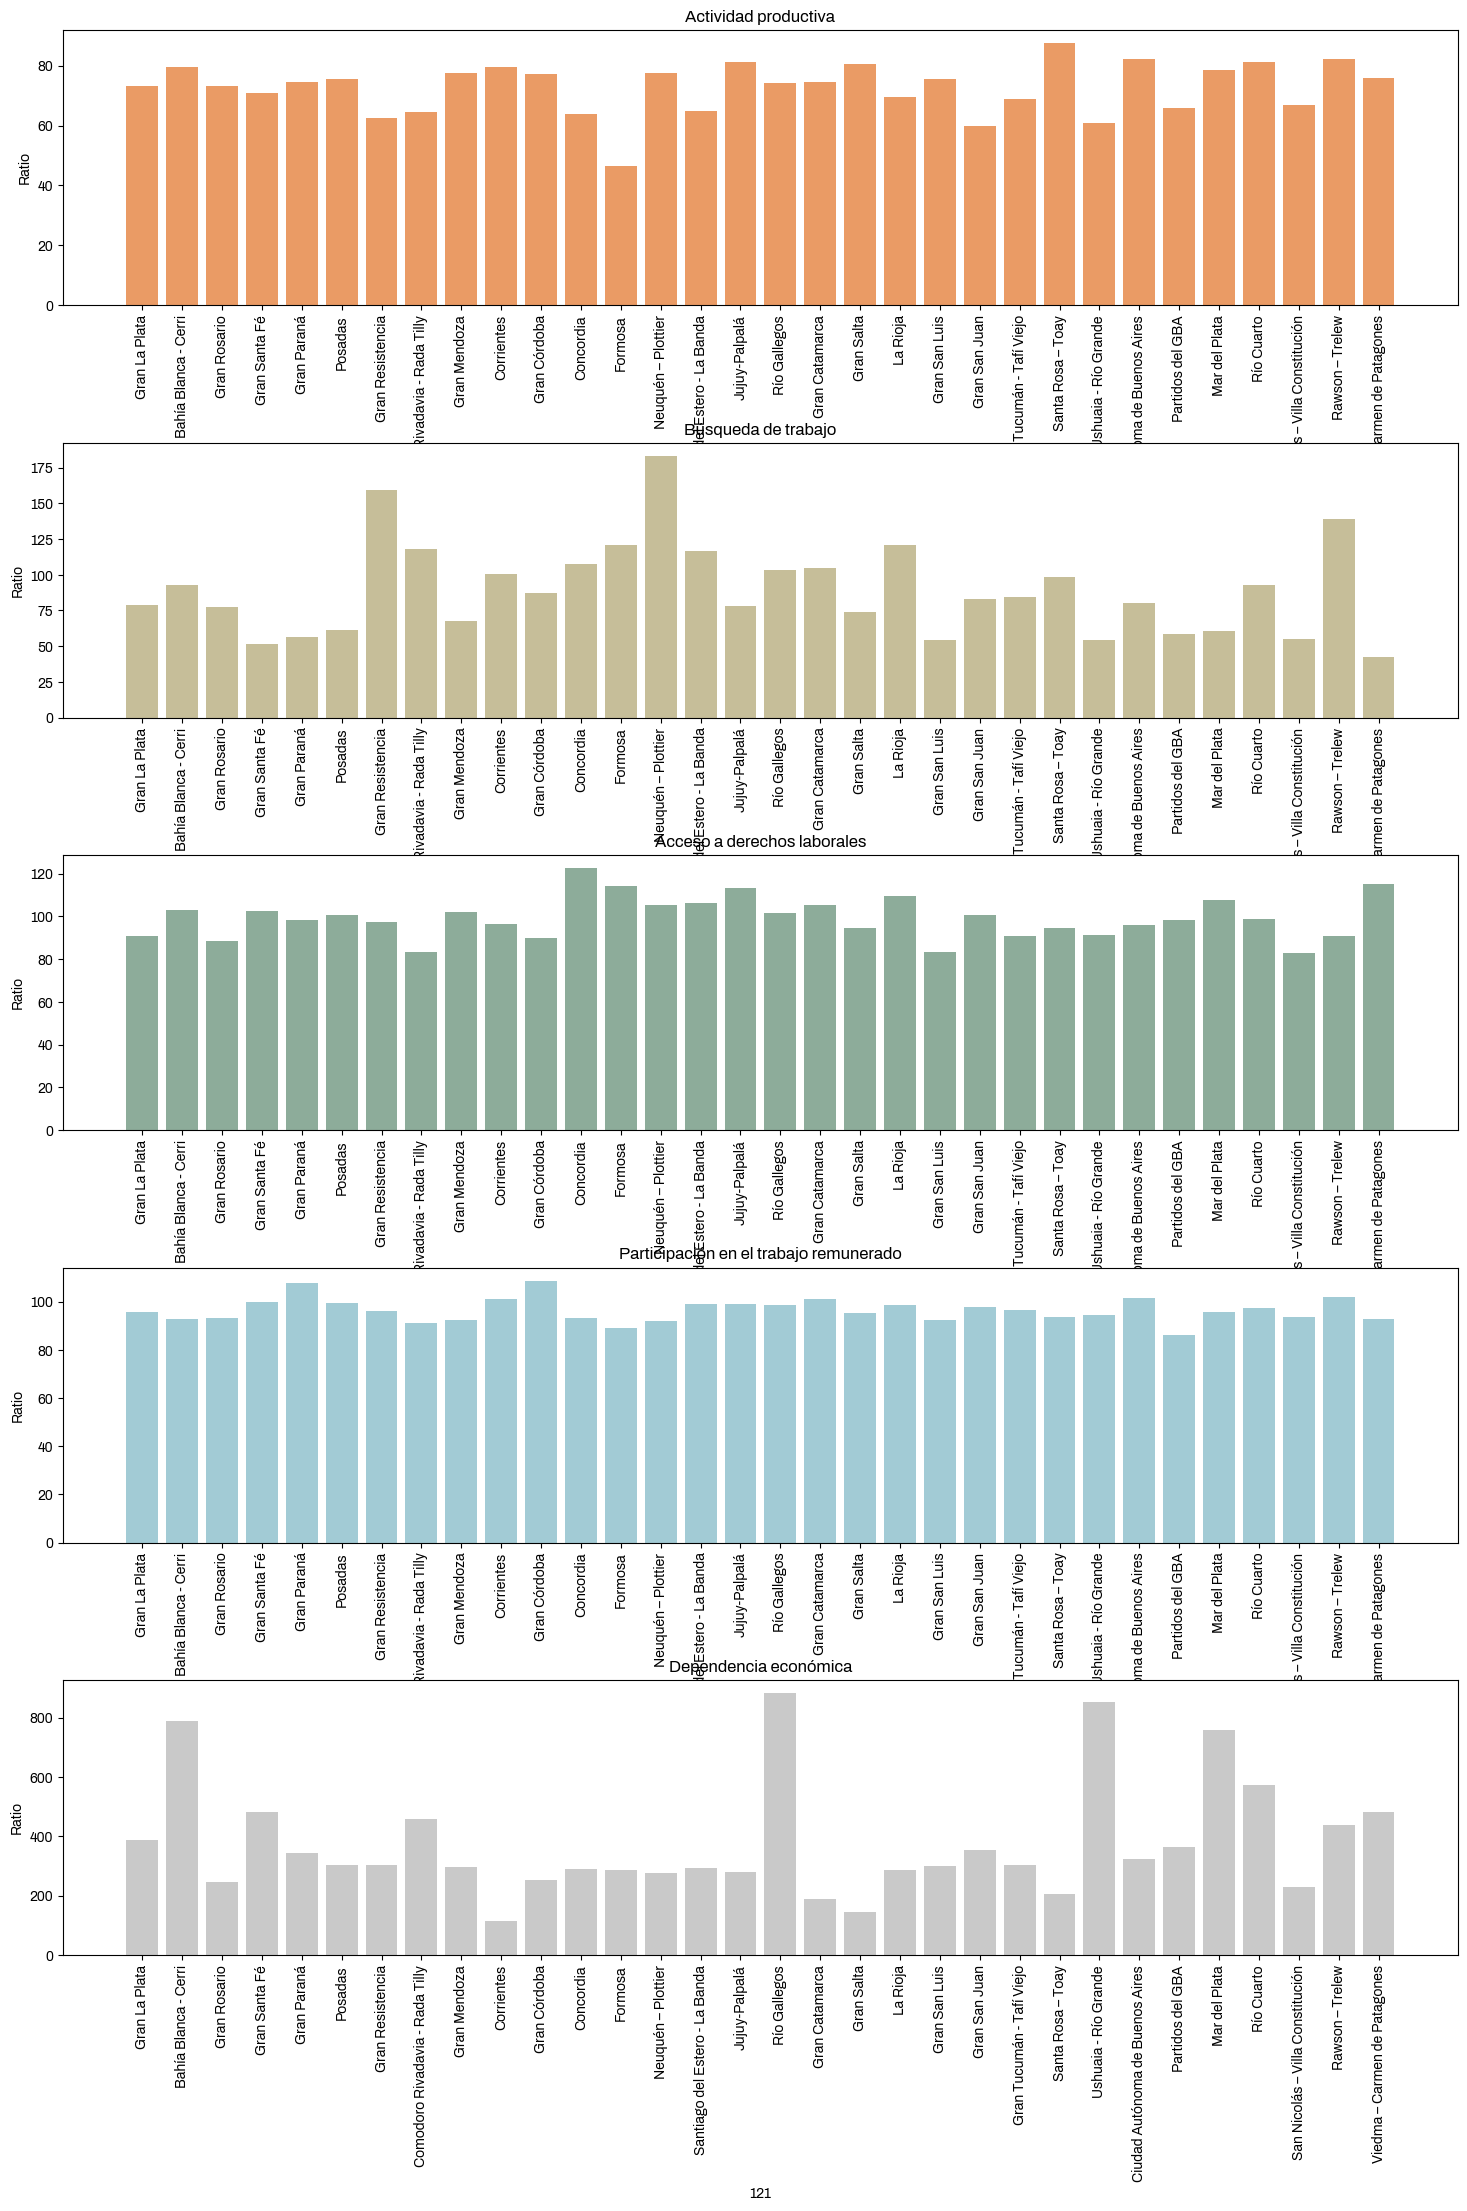

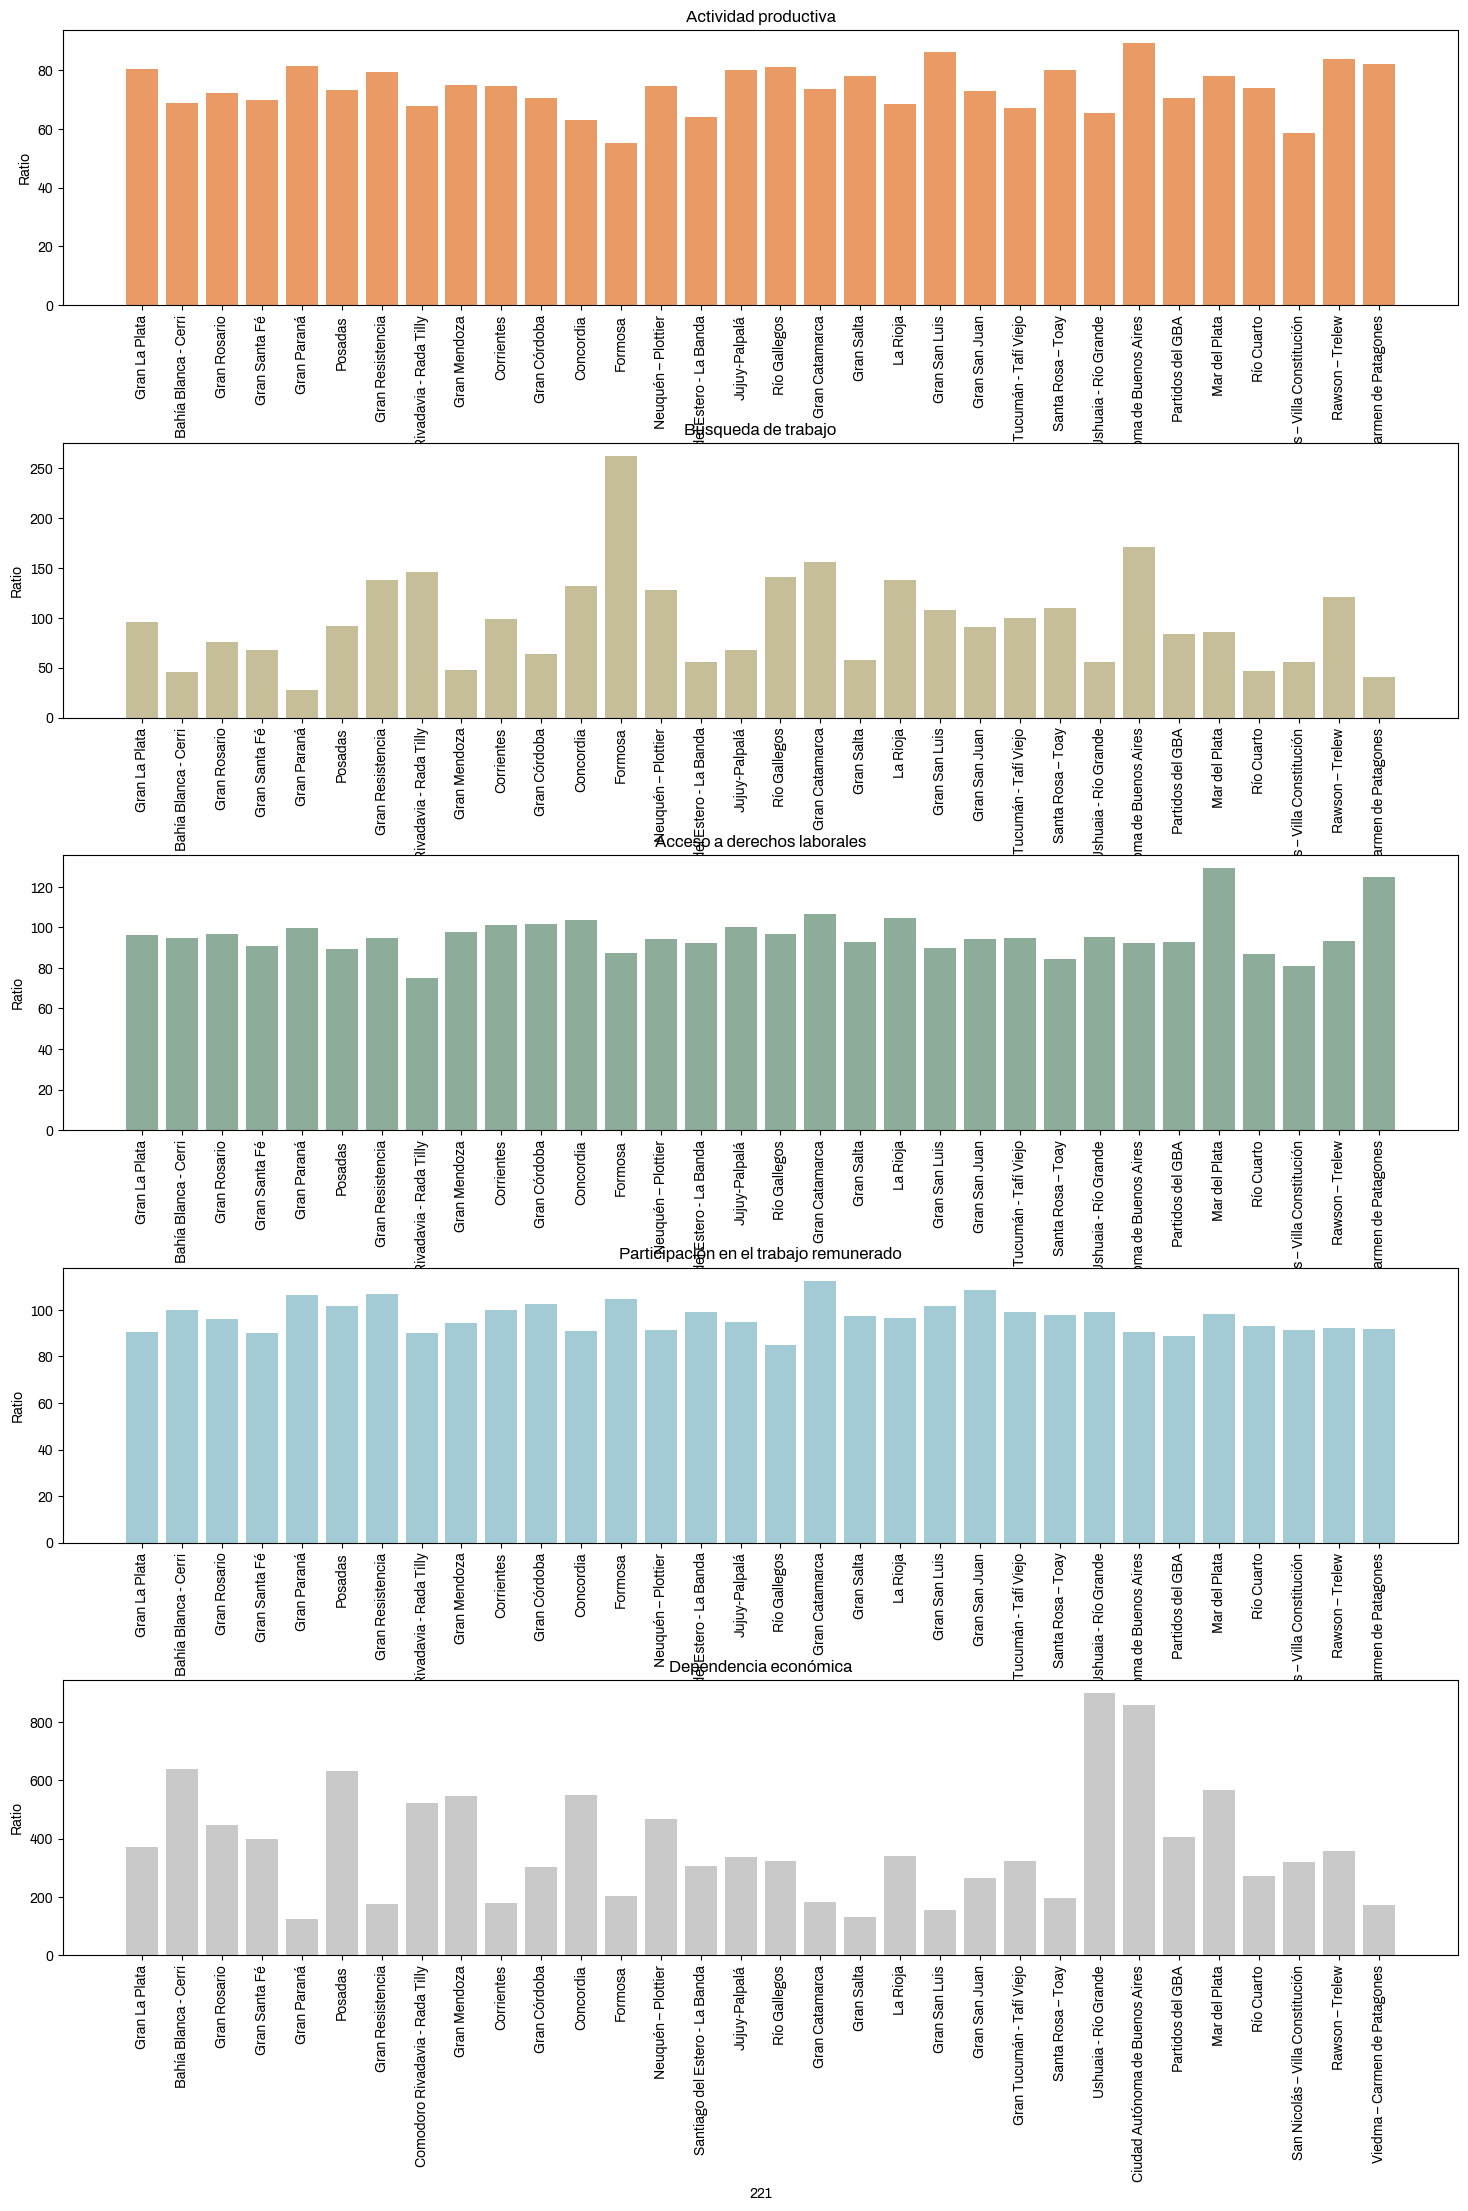

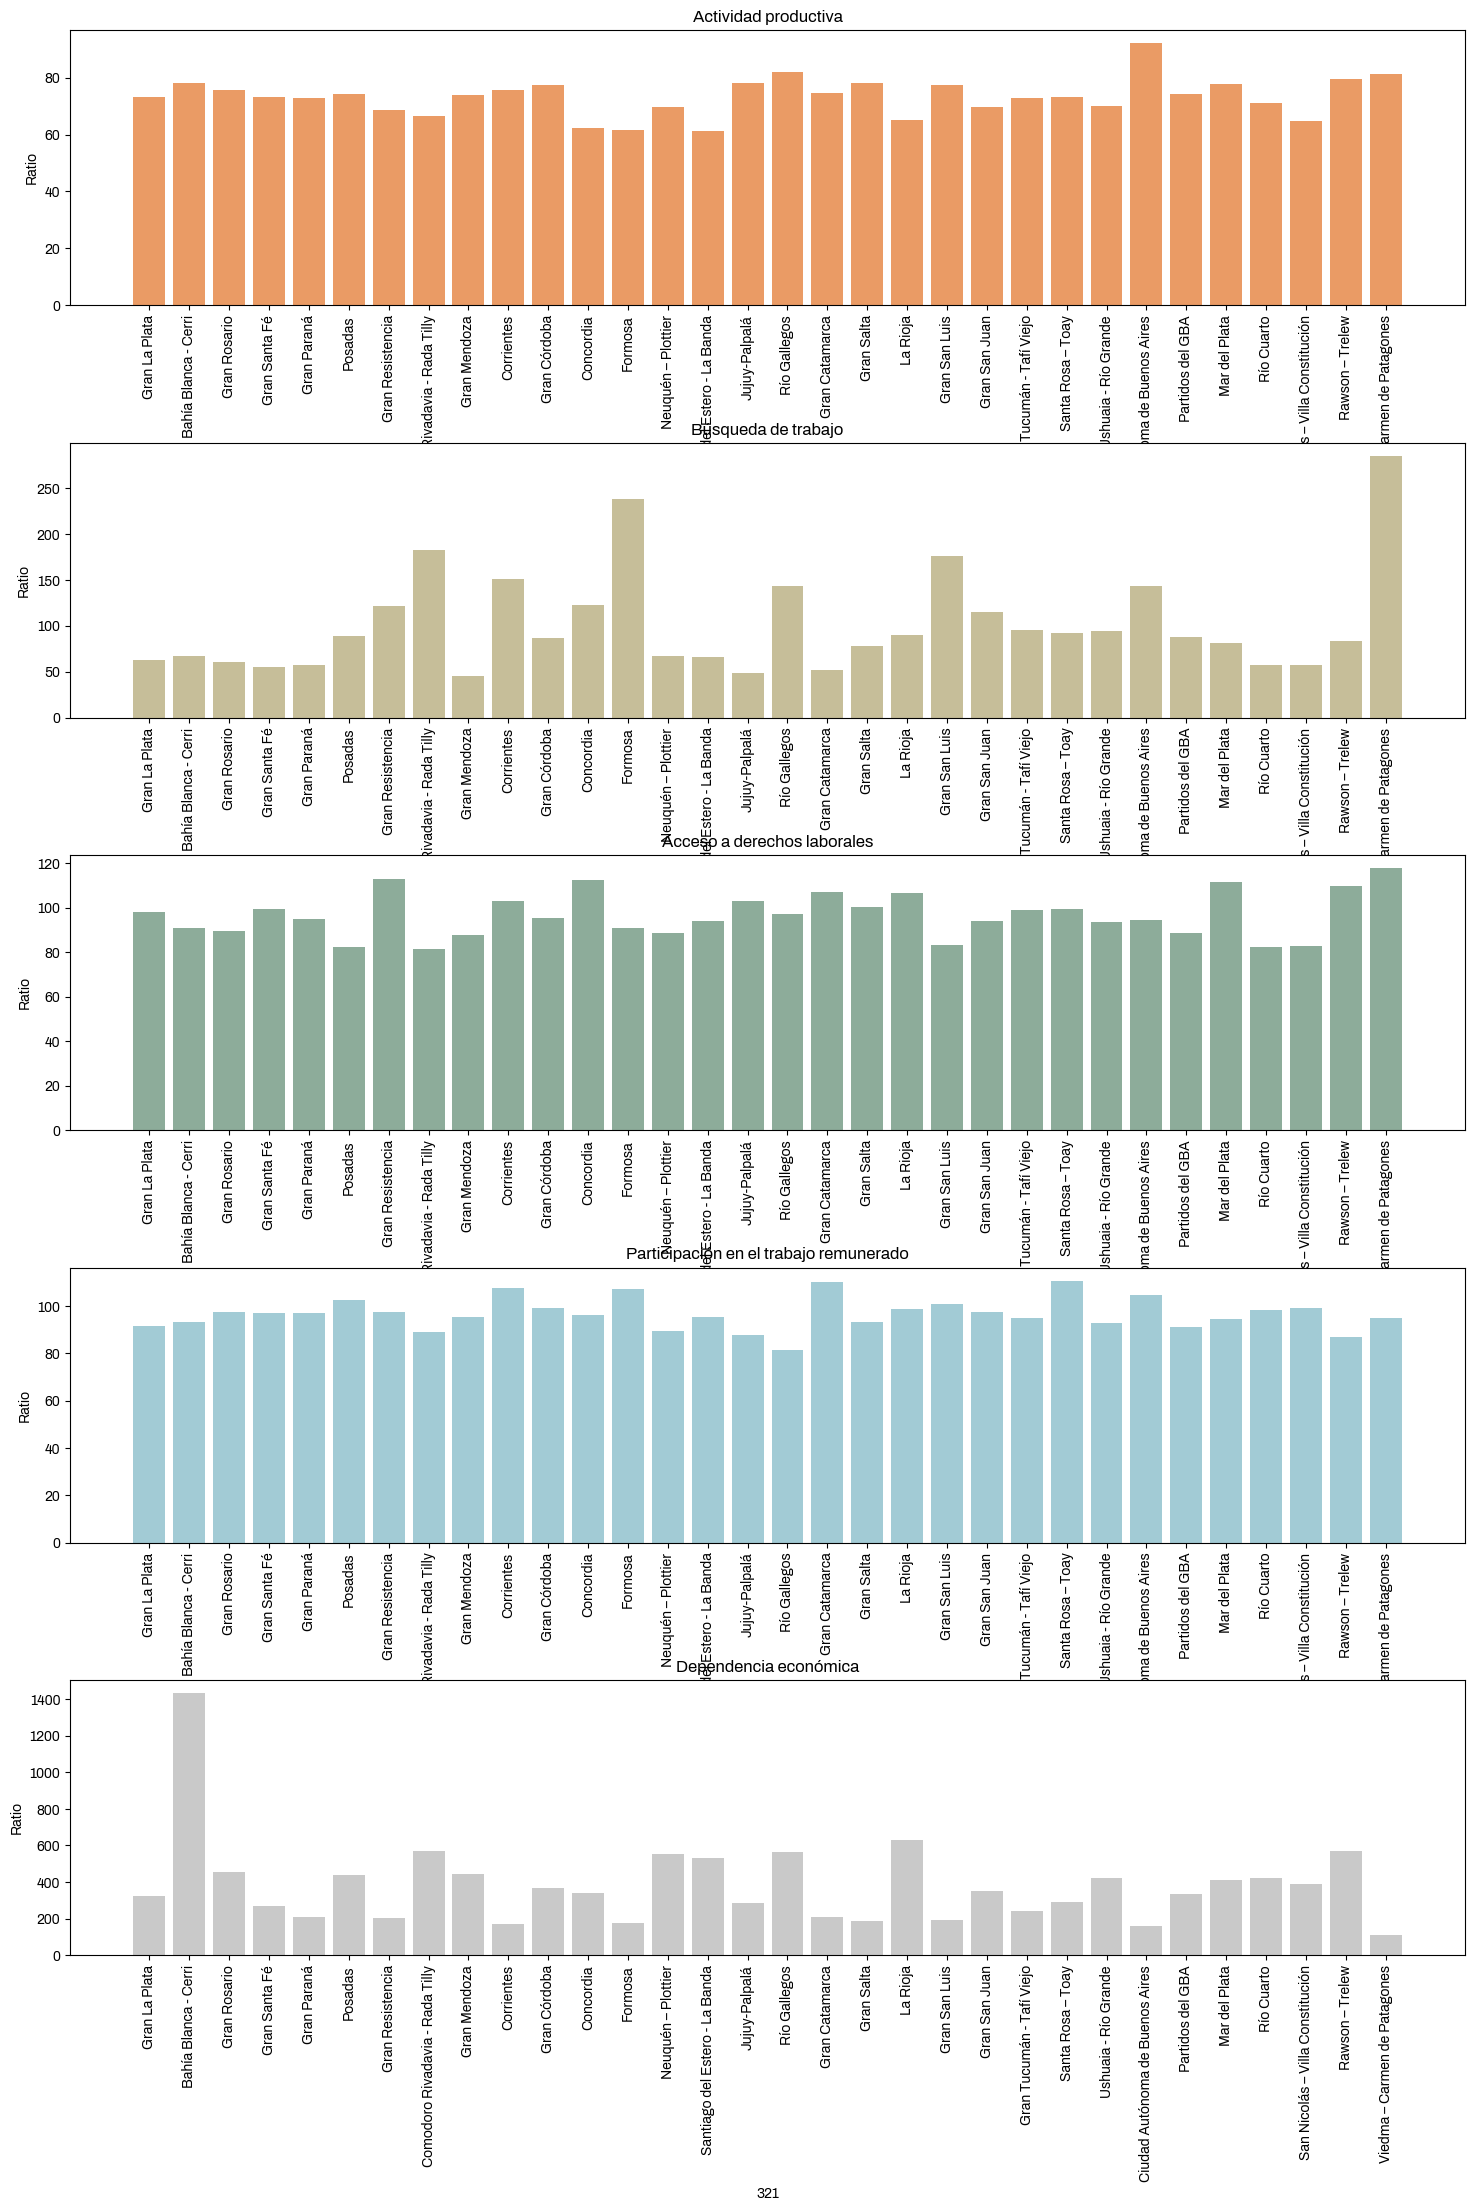

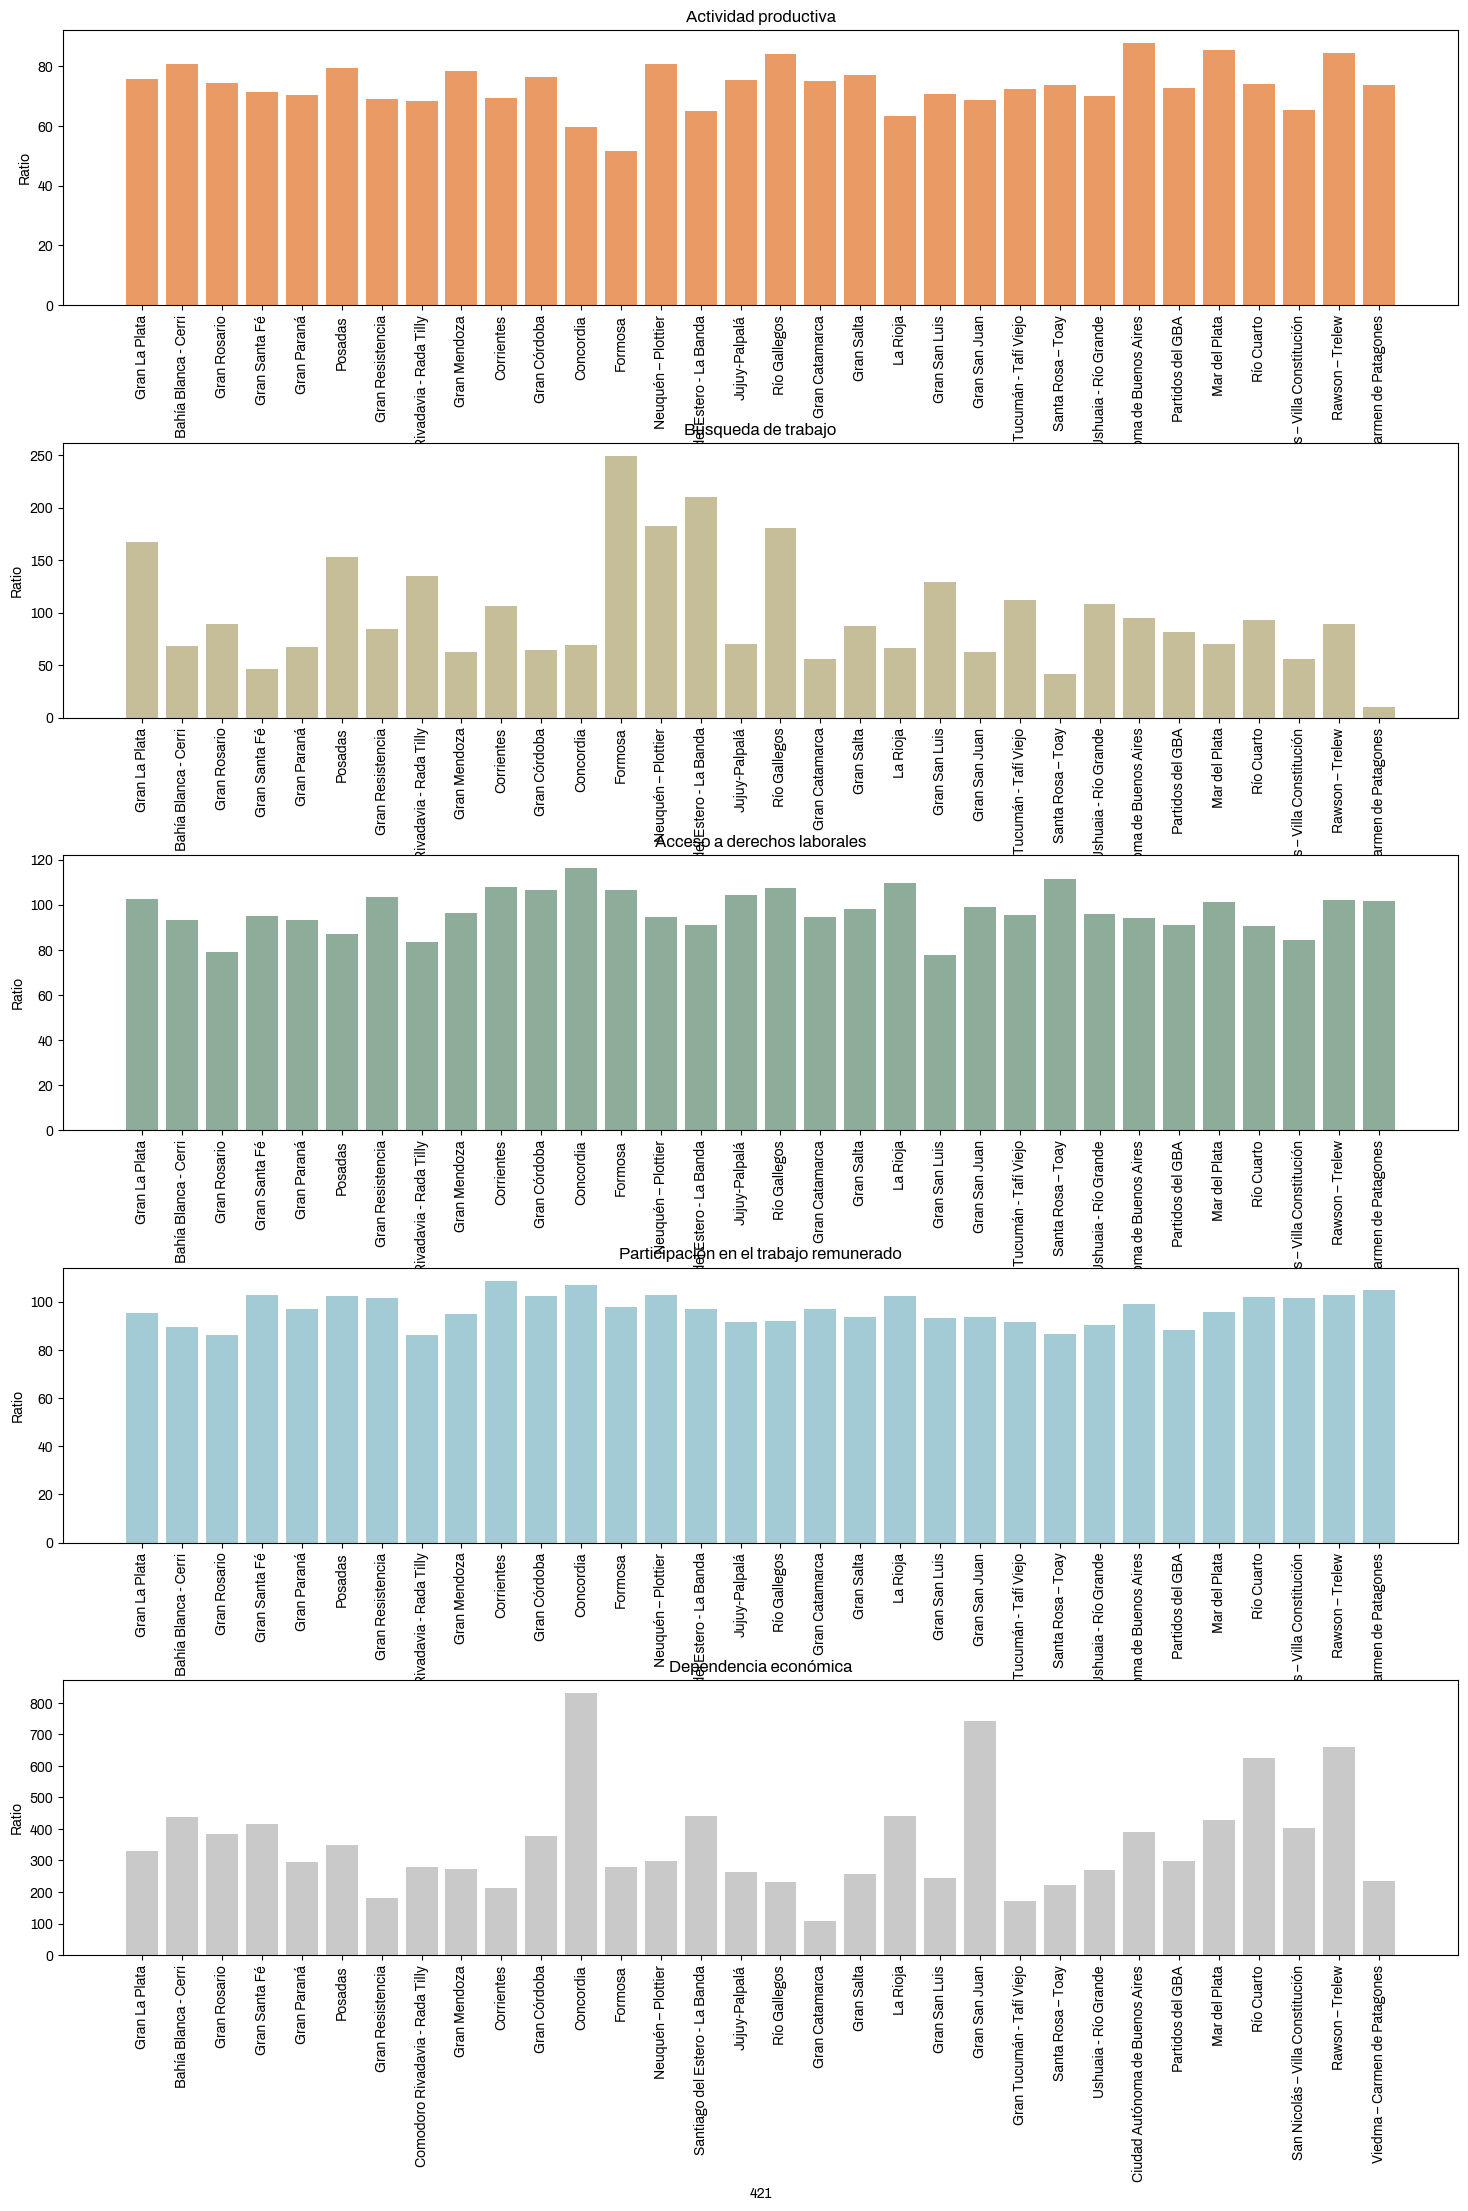

In [102]:

archivos = ['personas_T120.txt', 'personas_T220.txt', 
            'personas_T320.txt', 'personas_T420.txt', 
            'personas_T121.txt', 'personas_T221.txt', 
            'personas_T321.txt', 'personas_T421.txt']


for archivo in archivos:
    print(archivo)
    
    df = pd.read_csv(pathinput + archivo, delimiter=';', low_memory=False)
    trimestre = archivo.split('T')[1][0]
    
    tipo = 'Aglomerado' 
    dict_cod = dict_cod_aglomerado
    base = 'Individual'
    
    ratio_empleo, error_empleo = ratio_tasa_empleo(df, tipo=tipo, base=base)
    ratio_desempleo, error_desempleo = ratio_tasa_desempleo(df, tipo=tipo, base=base)
    ratio_informalidad, error_informalidad = ratio_tasa_registro(df, tipo=tipo, base=base)
    ratio_horas_remuneradas, error_horas_remuneradas = ratio_tasa_horas_remuneradas(df, tipo=tipo, base=base)
    ratio_poblacion_dependiente, error_poblacion_dependiente = ratio_tasa_poblacion_dependiente(df, tipo=tipo, base=base)
    ratio_ingreso_laboral, error_ingreso_laboral = ratio_ingreso_laboral_mensual(df, tipo=tipo, base=base)
    ratio_pobreza, error_pobreza = ratio_ingreso_laboral_mensual(df, tipo=tipo, base=base)
    
    # Combinar los ratios en un solo dataframe
    df_ratio = df_merge_ratios(ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                               ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza, dict_cod_aglomerado)
    

    xlabel = archivo.split('T')[1][0:3]


    # Define the list of indicators to plot
    indicators = ['Actividad productiva', 'Búsqueda de trabajo', 'Acceso a derechos laborales', 
                'Participación en el trabajo remunerado', 'Dependencia económica', \
                    #'Ingreso laboral', 'Pobreza'\
                        ]

    # Define the color palette for the lines
    colors = fundar_colors

    # Create a figure with subplots for each indicator
    fig, axes = plt.subplots(nrows=len(indicators), ncols=1, figsize=(18, 5*len(indicators)))

    # Iterate over each indicator and plot it in a separate subplot
    # Loop through indicators and plot
    for i, indicator in enumerate(indicators):
        ax = axes[i]
        ax.bar(df_ratio.index, df_ratio[indicator], color=colors[i], alpha=0.7)
        ax.set_title(indicator)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Ratio')
        # get the current xticks
        xticks = ax.get_xticks()

        # set new xtick labels
        new_xtick_labels = df_ratio.index.tolist()
        ax.set_xticklabels(new_xtick_labels)

        # rotate the xtick labels
        ax.tick_params(axis='x', rotation=90)

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    # Show the plot
    #plt.show()
    fig.savefig(pathfolder + xlabel + '.png', dpi=300, bbox_inches = 'tight')


In [97]:
xticklabels

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, '')]

In [78]:
archivos = ['personas_tot_urb_3T_20.txt', 'personas_tot_urb_3T_21.txt']

for archivo in archivos:
    print(archivo)
    
    df = pd.read_csv(pathinput + archivo, delimiter=';', low_memory=False)
    trimestre = archivo.split('T')[1][0]
    
    tipo =  'Urbano'
    dict_cod = dict_cod_provincia
    base = 'Individual'
    
    ratio_empleo, error_empleo = ratio_tasa_empleo(df, tipo=tipo, base=base)
    ratio_desempleo, error_desempleo = ratio_tasa_desempleo(df, tipo=tipo, base=base)
    ratio_informalidad, error_informalidad = ratio_tasa_registro(df, tipo=tipo, base=base)
    ratio_horas_remuneradas, error_horas_remuneradas = ratio_tasa_horas_remuneradas(df, tipo=tipo, base=base)
    ratio_poblacion_dependiente, error_poblacion_dependiente = ratio_tasa_poblacion_dependiente(df, tipo=tipo, base=base)
    ratio_ingreso_laboral, error_ingreso_laboral = ratio_ingreso_laboral_mensual(df, tipo=tipo, base=base)
    ratio_pobreza, error_pobreza = ratio_ingreso_laboral_mensual(df, tipo=tipo, base=base)
    
    # Combinar los ratios en un solo dataframe
    df_ratio = df_merge_ratios(ratio_empleo, ratio_desempleo, ratio_informalidad, ratio_horas_remuneradas, 
                               ratio_poblacion_dependiente, ratio_ingreso_laboral, ratio_pobreza, dict_cod_aglomerado)
    


In [76]:
len(df.AGLOMERADO.unique())

32

In [ ]:
path_basemaps = '/home/daniu/Documentos/fundar/indice-desigualdad-genero/basemaps/aglomerados_eph/'
path_basemaps = '/home/daniufundar/Documents/Fundar/indice-desigualdad-genero-fundar/basemaps/aglomerados_eph/'

gdf_aglomerados = gpd.read_file(path_basemaps + 'gdf_aglomerados_con_codigo.shp')
gdf_aglomerados['eph_codagl'] = gdf_aglomerados['eph_codagl'].astype(int)
gdf_aglomerados['index'] = gdf_aglomerados['eph_codagl'].map(dict_cod_aglomerado)

gdf_aglomerados.set_index(gdf_aglomerados['index'], inplace=True)

In [ ]:
df = pd.merge(gdf_aglomerados, df_ratio, left_index=True, right_index=True, how='inner')

In [ ]:
from shapely import wkt

pathmaps = '/Users/danielarisaro/Documents/fundar/desarrollo_social_GC/maps/'
pathmaps = '/home/daniufundar/Documents/Fundar/desarrollo_social_GC/maps/'

filename_dpto = 'departamento.csv'
filename_pcia = 'provincia.csv'

df_pcia = pd.read_csv(pathmaps + filename_pcia)

df_pcia['geometry'] = df_pcia['geom'].apply(wkt.loads)
gdf_pcia = gpd.GeoDataFrame(df_pcia, crs='epsg:4326')

gdf_pcia = gdf_pcia.set_index("fna")
gdf_pcia['boundary'] = gdf_pcia.boundary
gdf_pcia['area'] = gdf_pcia.area



In [ ]:
import descartes
from descartes import PolygonPatch

# Plot the shapefile
fig, ax = plt.subplots(figsize = (15,10))

# Plot the polygons
for i, row in gdf_pcia.iterrows():
    ax.add_patch(PolygonPatch(row['geometry'], fc='#999999', ec='black', lw=0.5, alpha=0.9, zorder=3))

# Set the x and y limits of the plot to the min and max values of the shapefile
xmin, ymin, xmax, ymax = gdf_pcia.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes([0.05, 0.05, 0.85, 0.85])

df.plot('Empleo', cmap='GnBu', ax=ax)

# Plot the polygons
for i, row in gdf_pcia.iterrows():
    ax.add_patch(PolygonPatch(row['geometry'], fc='#999999', ec='black', lw=0.5, alpha=0.9, zorder=3))

# Set the x and y limits of the plot to the min and max values of the shapefile
xmin, ymin, xmax, ymax = gdf_pcia.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)



In [ ]:
lat_s = -34.71
lat_n = -34.52
lon_w = -58.55
lon_e = -58.33

# Define the projection for the plot
projection = ccrs.PlateCarree()

In [ ]:
# Create a figure and axes
fig = plt.figure(figsize=(9,9))
ax = plt.axes([0.05, 0.05, 0.85, 0.85], projection=projection)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_extent([lon_w, lon_e, lat_s, lat_n], crs=ccrs.PlateCarree())
ax.set_aspect('equal', 'box')

In [ ]:


# Plot the data
df.plot(ax=ax, edgecolor='black', facecolor='gray')

# Add coastlines
ax.coastlines()

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
